# 1) Heuristische Regeln (Dispatching Rules)
Einfache Entscheidungsregeln, die lokal pro Operation bzw. Maschine angewendet werden.


In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
from utils.plotter import plot_gantt_jobs
from utils.plotter import plot_gantt_machines

## Sample laden

In [5]:
file_path = "data/jobshop_instances_named.json"
instance_name = "instance ft10"

In [6]:
# Datei laden
with open(file_path, "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance = jobshop_instances[instance_name]

# JSON → Matrix (list of lists)
job_order = sorted(instance, key=lambda x: int(x.split()[1])) # korrekte Reihenfolge sichern
matrix = [instance[job_name] for job_name in job_order]

for job in matrix:
    print(job)

[[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
[[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
[[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
[[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
[[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
[[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
[[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
[[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
[[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
[[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]


## 1.1) FCFS – First Come First Serve
Jobs werden in der Reihenfolge verarbeitet, in der sie verfügbar sind.


In [8]:
def schedule_fcfs(matrix):
    job_ready = [0] * len(matrix)
    machine_ready = {}
    schedule = []

    for job_id, operations in enumerate(matrix):
        for machine, duration in operations:
            start = max(job_ready[job_id], machine_ready.get(machine, 0))
            end = start + duration

            schedule.append({
                'Job': f'Job {job_id}',
                'Machine': f'M{machine}',
                'Start': start,
                'Duration': duration,
                'End': end
            })

            job_ready[job_id] = end
            machine_ready[machine] = end

    return pd.DataFrame(schedule)

df_fcfs = schedule_fcfs(matrix)
df_fcfs

,Job,Machine,Start,Duration,End
0,Job 0,M0,0,29,29
1,Job 0,M1,29,78,107
2,Job 0,M2,107,9,116
3,Job 0,M3,116,36,152
4,Job 0,M4,152,49,201
...,...,...,...,...,...
95,Job 9,M9,3084,76,3160
96,Job 9,M5,3160,47,3207
97,Job 9,M3,3207,52,3259
98,Job 9,M4,3259,90,3349


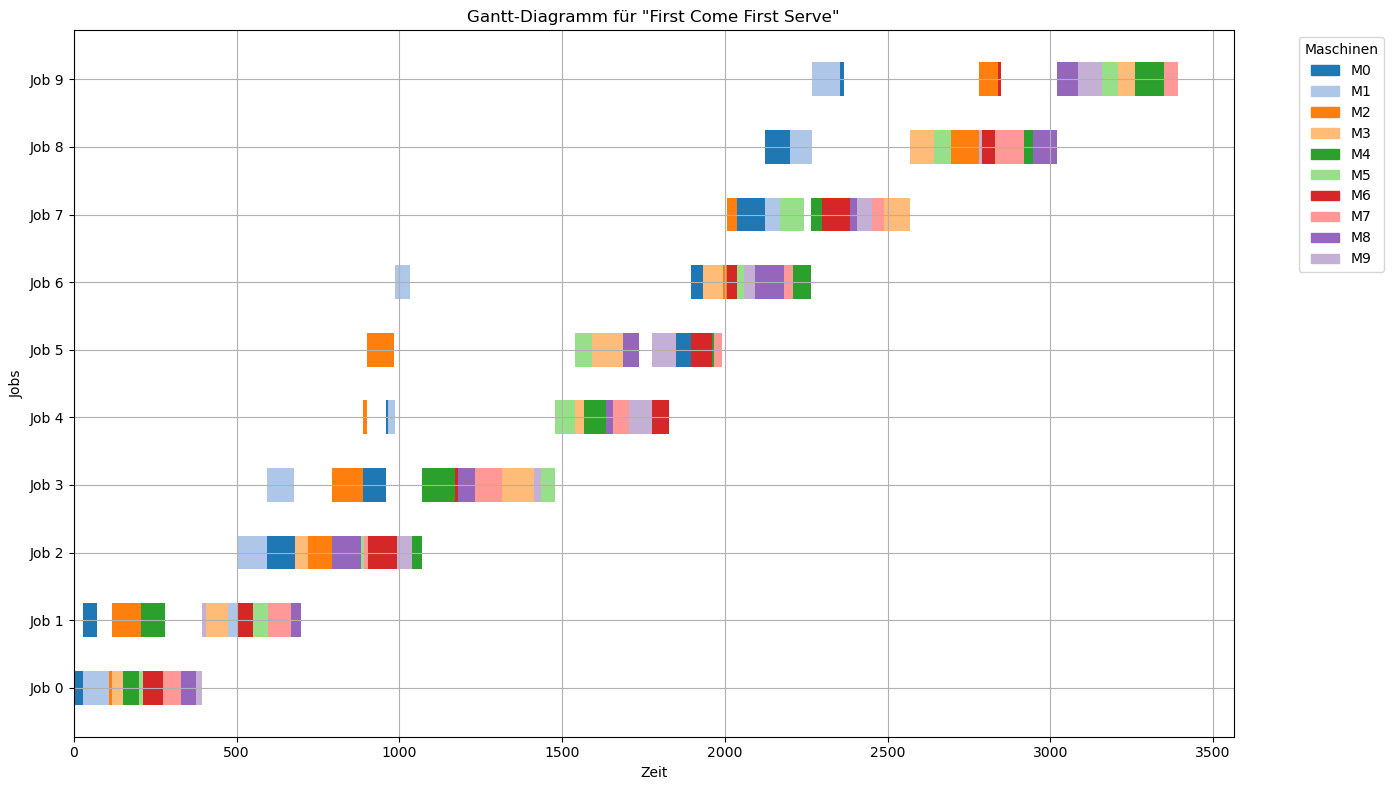

In [9]:
plot_gantt_jobs(df_fcfs, 'Gantt-Diagramm für "First Come First Serve"')

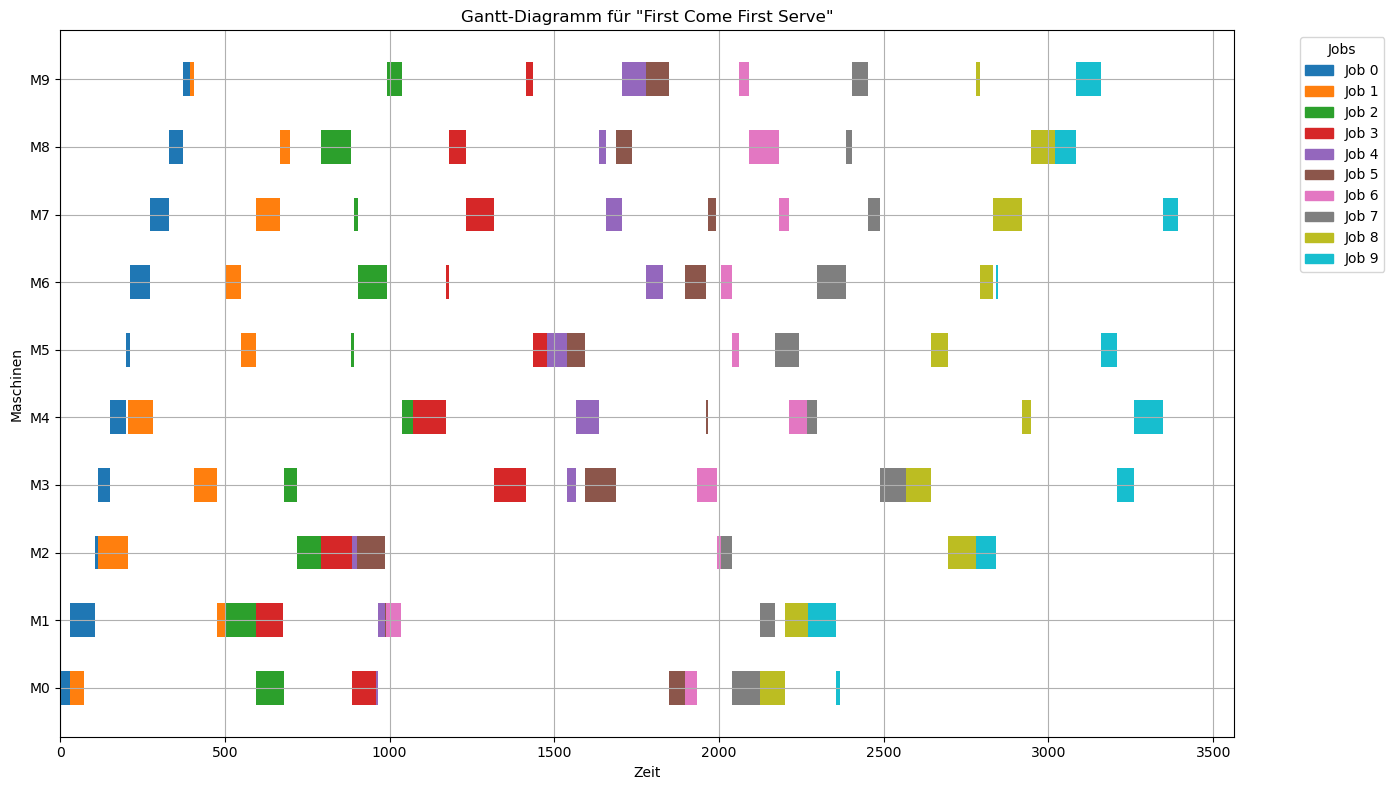

In [10]:
plot_gantt_machines(df_fcfs, 'Gantt-Diagramm für "First Come First Serve"')

## 1.2) SPT – Shortest Processing Time
Die Operation mit der kürzesten Bearbeitungszeit wird zuerst geplant.


In [12]:
def schedule_spt(matrix):
    num_jobs = len(matrix)
    num_ops = len(matrix[0])

    job_ready = [0] * num_jobs
    machine_ready = {}
    job_ops_pointer = [0] * num_jobs
    schedule = []

    while any(p < num_ops for p in job_ops_pointer):
        available_ops = []

        for job_id in range(num_jobs):
            op_idx = job_ops_pointer[job_id]
            if op_idx < num_ops:
                machine, duration = matrix[job_id][op_idx]
                ready_time = max(job_ready[job_id], machine_ready.get(machine, 0))
                available_ops.append({
                    'JobID': job_id,
                    'Machine': machine,
                    'Duration': duration,
                    'ReadyTime': ready_time
                })

        selected = min(available_ops, key=lambda x: x['Duration'])

        job_id = selected['JobID']
        machine = selected['Machine']
        duration = selected['Duration']
        start = selected['ReadyTime']
        end = start + duration

        schedule.append({
            'Job': f'Job {job_id}',
            'Machine': f'M{machine}',
            'Start': start,
            'Duration': duration,
            'End': end
        })

        job_ready[job_id] = end
        machine_ready[machine] = end
        job_ops_pointer[job_id] += 1

    return pd.DataFrame(schedule)

df_spt = schedule_spt(matrix)
df_spt

,Job,Machine,Start,Duration,End
0,Job 4,M2,0,14,14
1,Job 4,M0,14,6,20
2,Job 4,M1,20,22,42
3,Job 0,M0,20,29,49
4,Job 7,M2,14,31,45
...,...,...,...,...,...
95,Job 3,M8,2348,52,2400
96,Job 3,M7,2400,85,2485
97,Job 3,M3,2485,98,2583
98,Job 3,M9,2583,22,2605


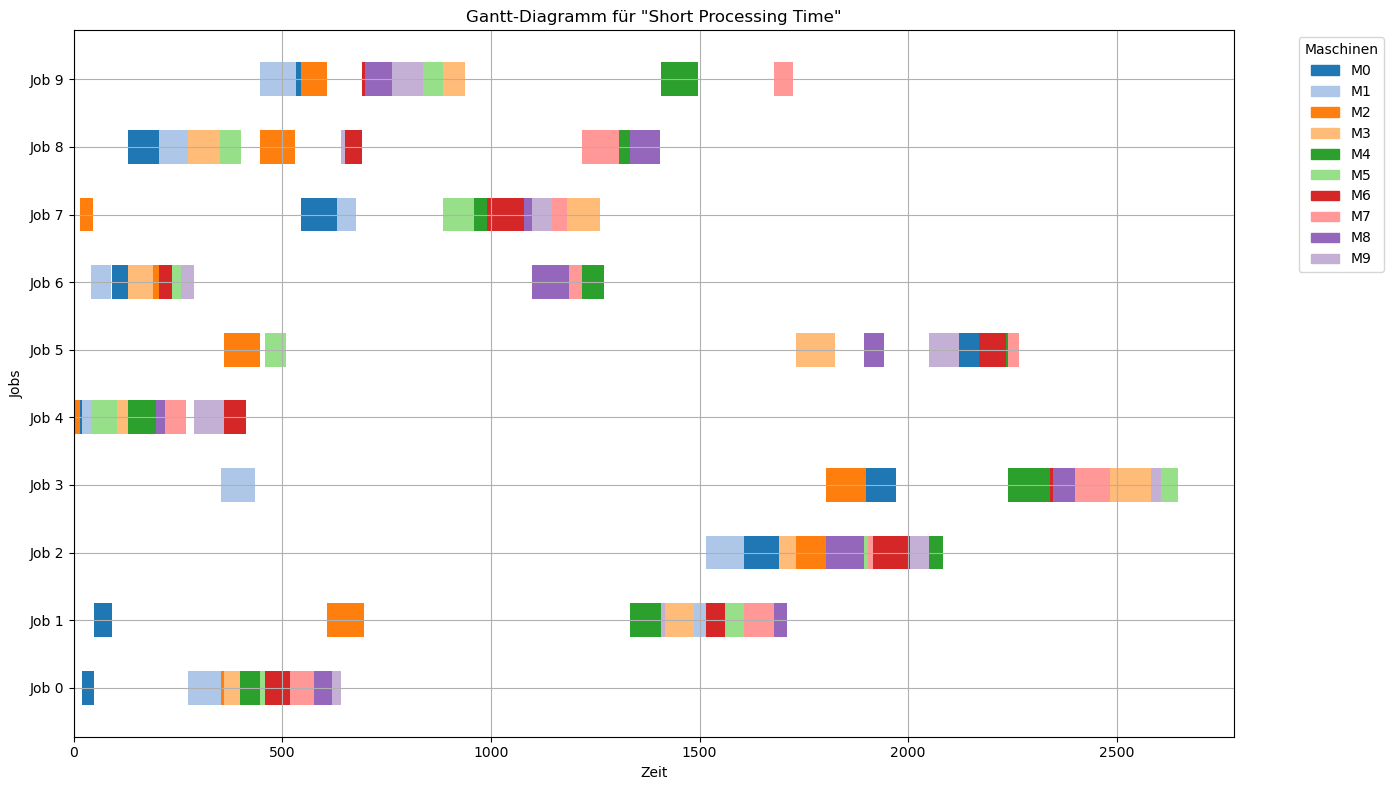

In [13]:
plot_gantt_jobs(df_spt, 'Gantt-Diagramm für "Short Processing Time"')

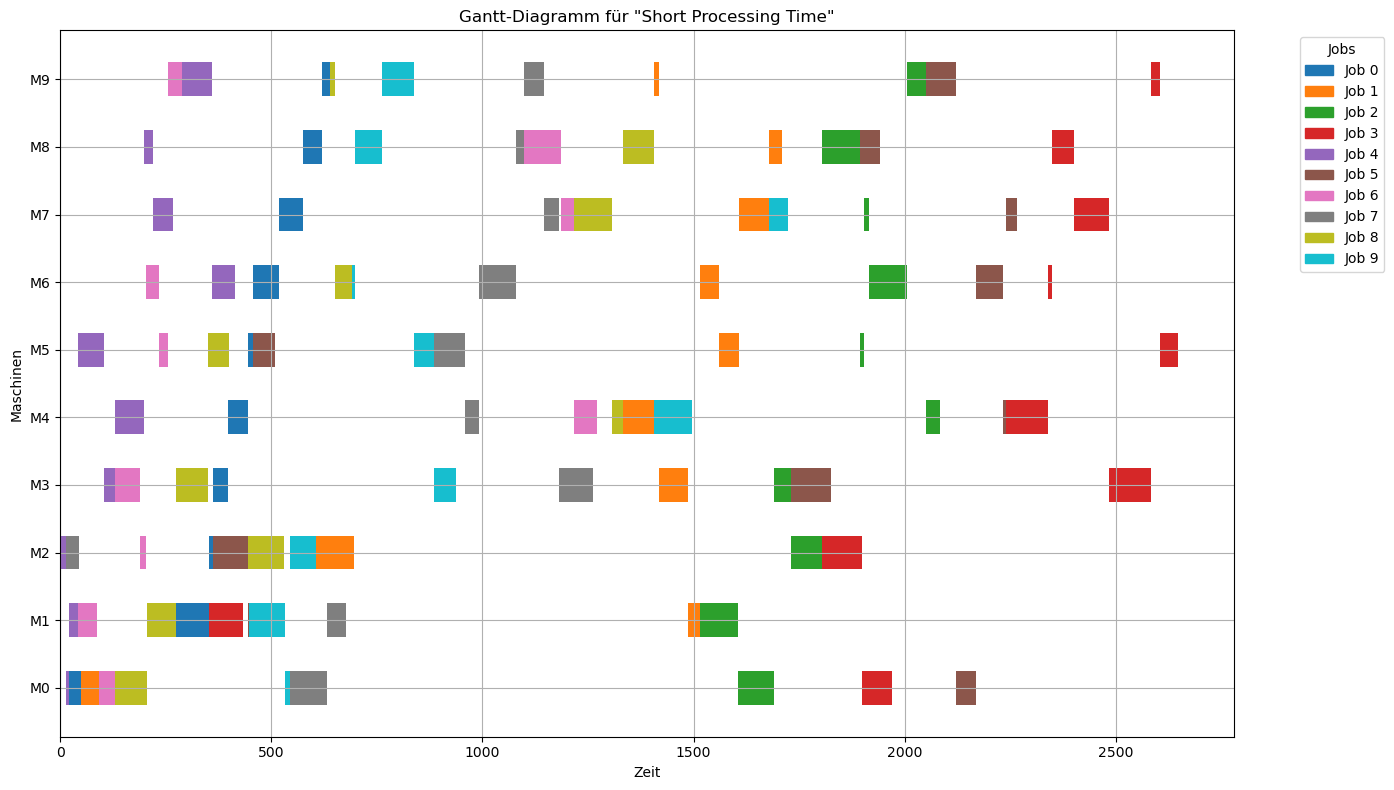

In [14]:
plot_gantt_machines(df_spt, 'Gantt-Diagramm für "Short Processing Time"')

## 1.3) LPT – Longest Processing Time
Die Operation mit der längsten Bearbeitungszeit wird zuerst eingeplant.


In [16]:
def schedule_lpt(matrix):
    num_jobs = len(matrix)
    num_ops = len(matrix[0])

    job_ready = [0] * num_jobs
    machine_ready = {}
    job_ops_pointer = [0] * num_jobs
    schedule = []

    while any(p < num_ops for p in job_ops_pointer):
        available_ops = []

        for job_id in range(num_jobs):
            op_idx = job_ops_pointer[job_id]
            if op_idx < num_ops:
                machine, duration = matrix[job_id][op_idx]
                ready_time = max(job_ready[job_id], machine_ready.get(machine, 0))
                available_ops.append({
                    'JobID': job_id,
                    'Machine': machine,
                    'Duration': duration,
                    'ReadyTime': ready_time
                })

        # Längste Dauer zuerst auswählen
        selected = max(available_ops, key=lambda x: x['Duration'])

        job_id = selected['JobID']
        machine = selected['Machine']
        duration = selected['Duration']
        start = selected['ReadyTime']
        end = start + duration

        schedule.append({
            'Job': f'Job {job_id}',
            'Machine': f'M{machine}',
            'Start': start,
            'Duration': duration,
            'End': end
        })

        job_ready[job_id] = end
        machine_ready[machine] = end
        job_ops_pointer[job_id] += 1

    return pd.DataFrame(schedule)


In [17]:
df_lpt = schedule_spt(matrix)
df_lpt

,Job,Machine,Start,Duration,End
0,Job 4,M2,0,14,14
1,Job 4,M0,14,6,20
2,Job 4,M1,20,22,42
3,Job 0,M0,20,29,49
4,Job 7,M2,14,31,45
...,...,...,...,...,...
95,Job 3,M8,2348,52,2400
96,Job 3,M7,2400,85,2485
97,Job 3,M3,2485,98,2583
98,Job 3,M9,2583,22,2605


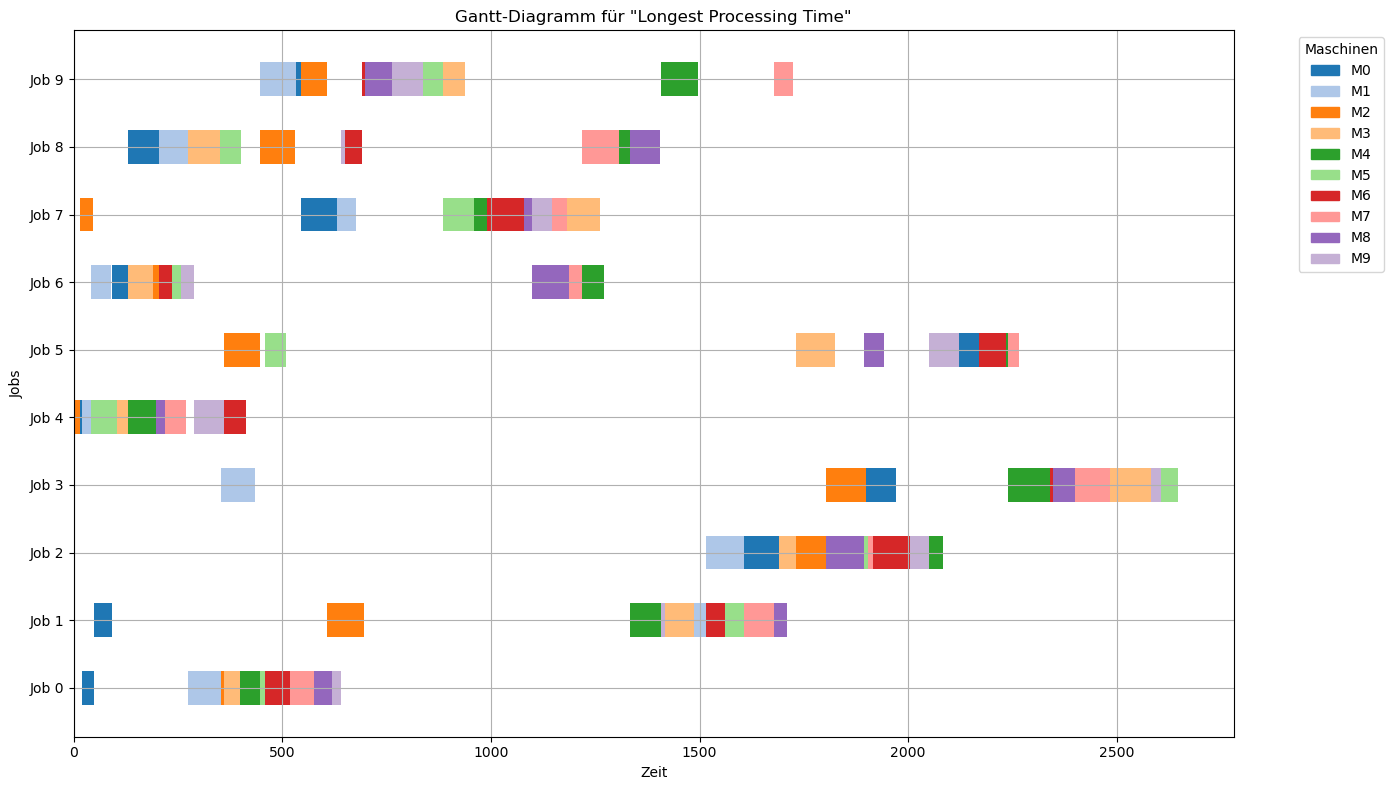

In [18]:
plot_gantt_jobs(df_lpt, 'Gantt-Diagramm für "Longest Processing Time"')

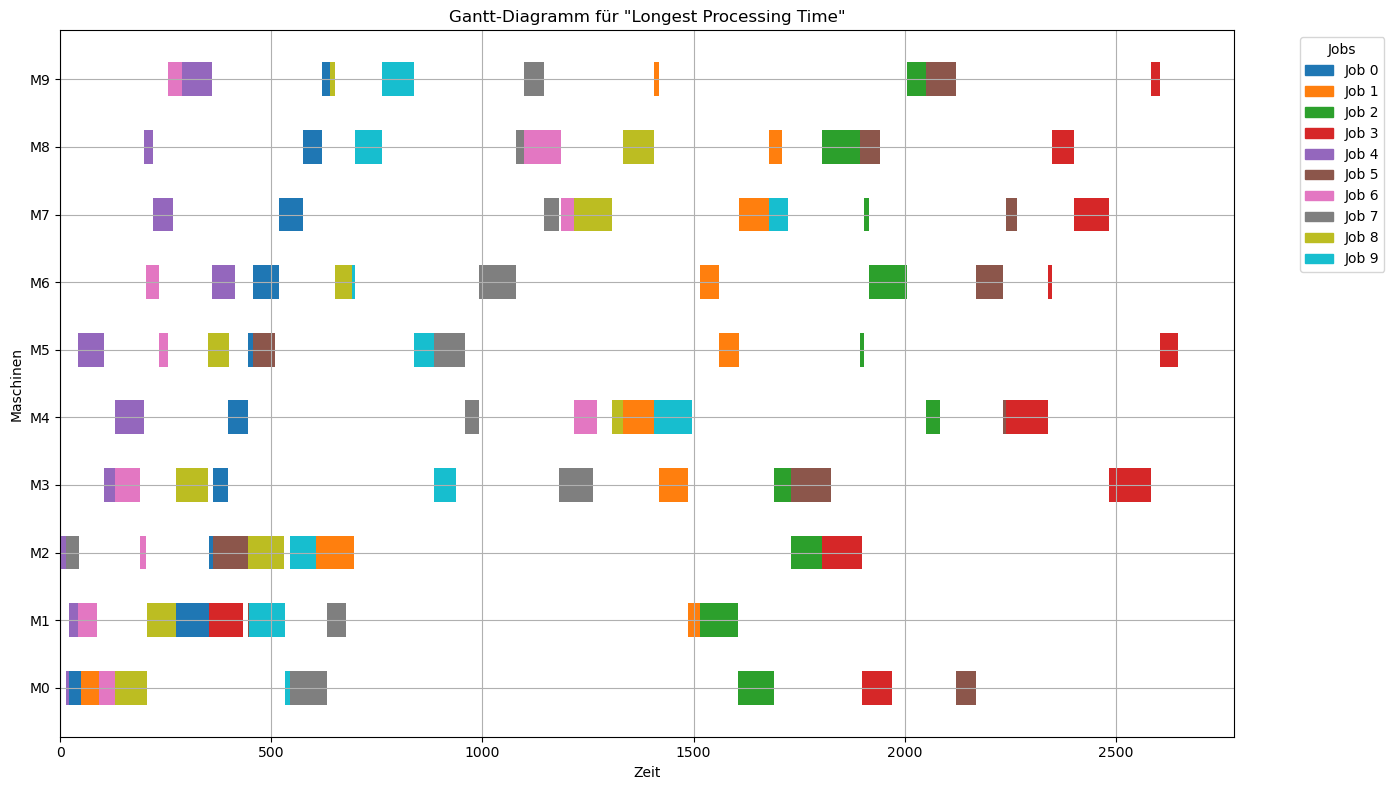

In [19]:
plot_gantt_machines(df_lpt, 'Gantt-Diagramm für "Longest Processing Time"')

## 1.4) Giffler-Thompson-Algorithmus 
(vereinfachte Version mit SPT als Konfliktentscheidungsregel)

Konstruktiver Algorithmus zur Erstellung konfliktfreier Schedules.
Er erweitert heuristische Regeln um systematische Konfliktauflösung auf Maschinenebene.


In [21]:
import pandas as pd

def schedule_gt(matrix, conflict_rule="SPT"):
    num_jobs = len(matrix)
    num_ops = len(matrix[0])

    job_ready = [0] * num_jobs
    machine_ready = {}
    job_ops_pointer = [0] * num_jobs
    schedule = []

    total_operations = num_jobs * num_ops
    scheduled_ops = 0

    while scheduled_ops < total_operations:
        available_ops = []

        for job_id in range(num_jobs):
            op_idx = job_ops_pointer[job_id]
            if op_idx < num_ops:
                machine, duration = matrix[job_id][op_idx]
                est = max(job_ready[job_id], machine_ready.get(machine, 0))
                available_ops.append({
                    'JobID': job_id,
                    'Machine': machine,
                    'Duration': duration,
                    'EST': est,
                    'EFT': est + duration
                })

        # Wähle Operation mit minimaler EFT
        min_eft_op = min(available_ops, key=lambda x: x['EFT'])
        conflict_machine = min_eft_op['Machine']
        conflict_time = min_eft_op['EFT']

        # Finde alle Operationen mit derselben Maschine, deren EST < conflict_time
        conflicting_ops = [
            op for op in available_ops
            if op['Machine'] == conflict_machine and op['EST'] < conflict_time
        ]

        # Entscheidung: wähle nach Regel (hier SPT)
        if conflict_rule == "SPT":
            selected = min(conflicting_ops, key=lambda x: x['Duration'])
        elif conflict_rule == "random":
            import random
            selected = random.choice(conflicting_ops)
        else:
            selected = conflicting_ops[0]  # FCFS oder Standard

        # Planen
        job_id = selected['JobID']
        machine = selected['Machine']
        duration = selected['Duration']
        start = selected['EST']
        end = start + duration

        schedule.append({
            'Job': f'Job {job_id}',
            'Machine': f'M{machine}',
            'Start': start,
            'Duration': duration,
            'End': end
        })

        job_ready[job_id] = end
        machine_ready[machine] = end
        job_ops_pointer[job_id] += 1
        scheduled_ops += 1

    return pd.DataFrame(schedule)


In [22]:
df_gt = schedule_gt(matrix, "SPT")
df_gt

,Job,Machine,Start,Duration,End
0,Job 4,M2,0,14,14
1,Job 4,M0,14,6,20
2,Job 4,M1,20,22,42
3,Job 7,M2,14,31,45
4,Job 0,M0,20,29,49
...,...,...,...,...,...
95,Job 2,M6,1258,89,1347
96,Job 3,M9,1329,22,1351
97,Job 3,M5,1351,43,1394
98,Job 2,M9,1351,45,1396


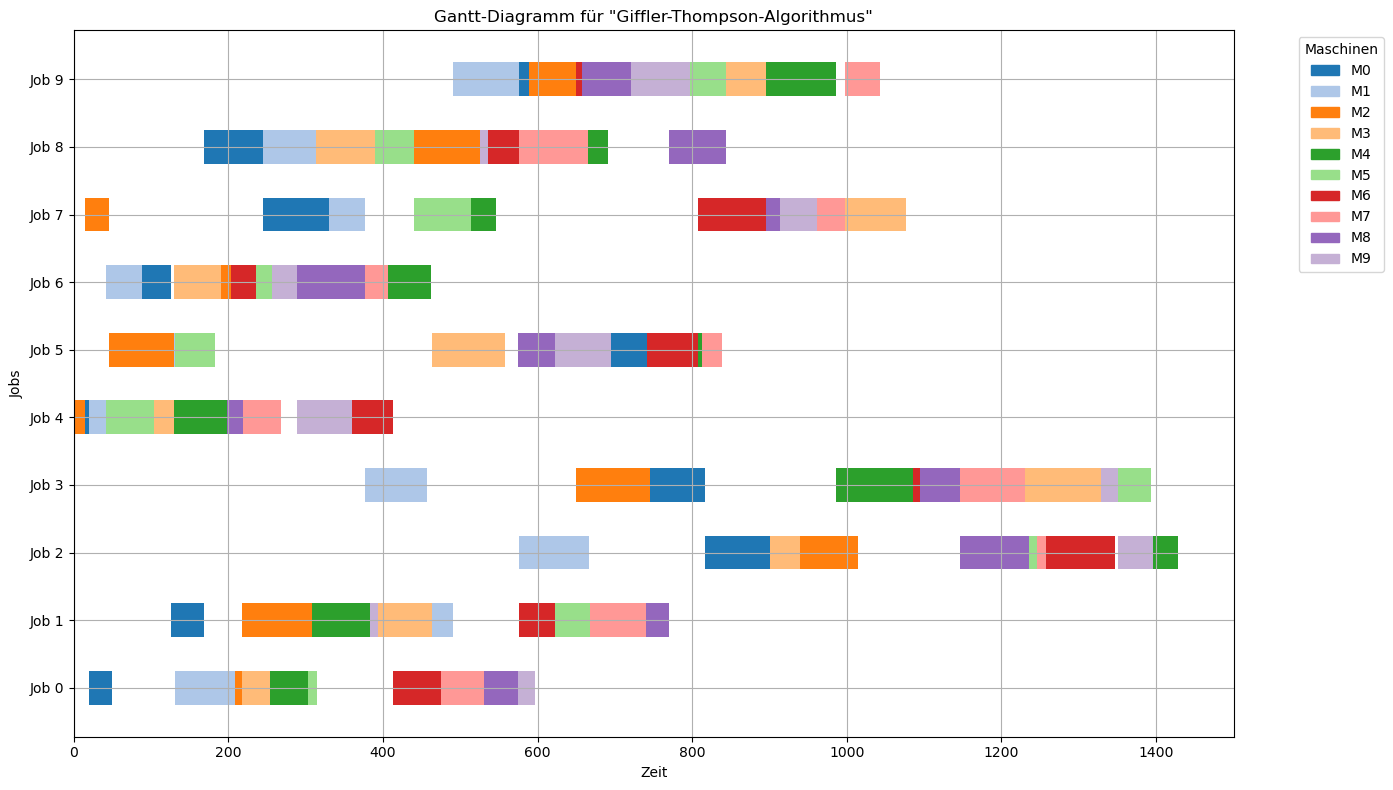

In [23]:
plot_gantt_jobs(df_gt, 'Gantt-Diagramm für "Giffler-Thompson-Algorithmus"')

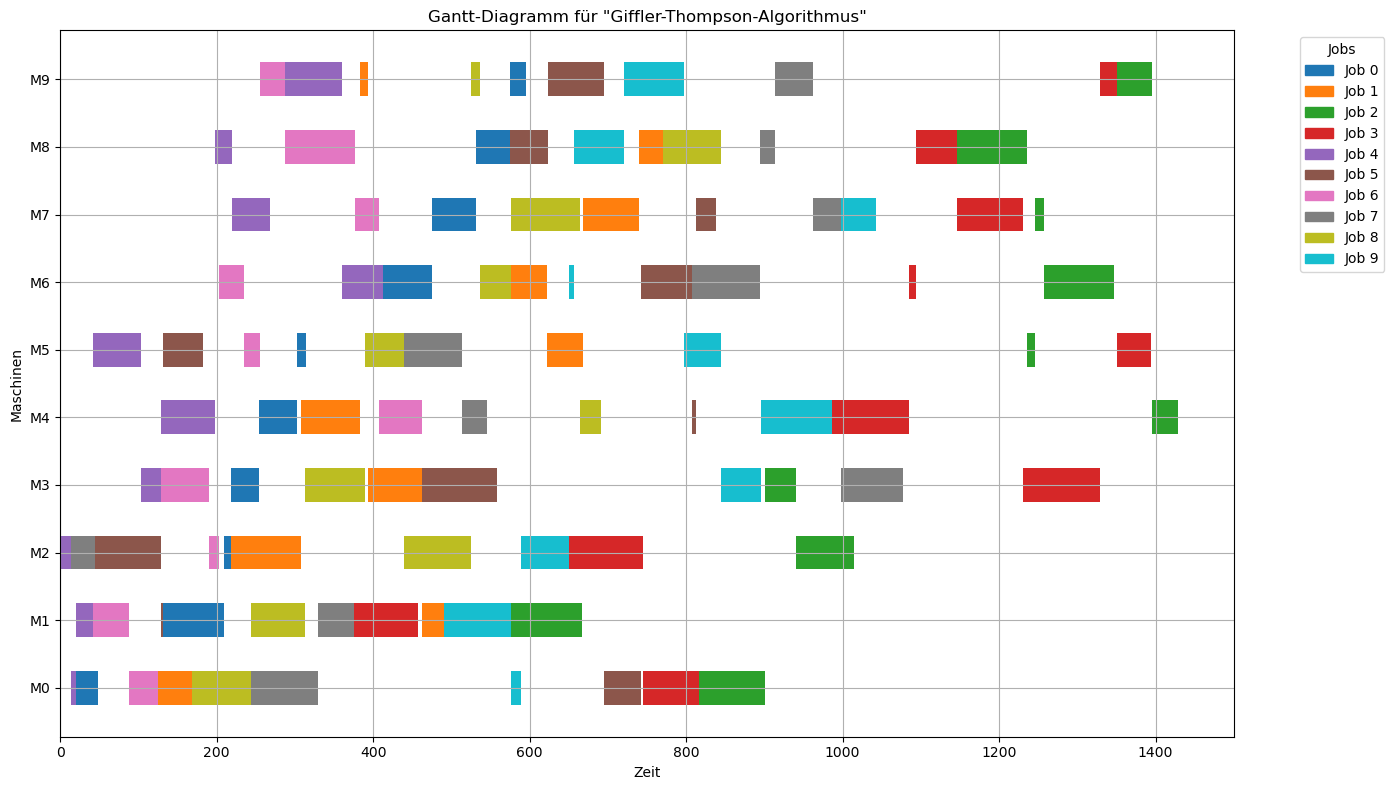

In [24]:
plot_gantt_machines(df_gt, 'Gantt-Diagramm für "Giffler-Thompson-Algorithmus"')